In [1]:
import gzip
import json
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import networkx as nx
from networkx.algorithms import approximation
from networkx.algorithms import bipartite
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Basics about Data

### [design].json.gz – Feature data for each design, including instance and net data

counter.json.gz: 
- Simple starting example
- 23 cells & 29 nets
- name(str): name of the instance
- id(int): index of the instance in the array
    - index just in this chip
- xloc, yloc(int): location of the instance in database units (DBU)
- cell(int): master library cell ID (index)
    - what kind of cell that is being instantiated
- orient(int): number from 0 to 7 for orientation of instance

In [2]:
with gzip.open("../data/DigIC_dataset/counter/1/counter.json.gz", 'rb') as f:
    counter = json.loads(f.read().decode('utf-8'))

In [3]:
counter

{'instances': [{'name': 'clk_gate_value_reg/latch',
   'id': 0,
   'xloc': 2560,
   'yloc': 7680,
   'cell': 23,
   'orient': 0},
  {'name': 'value_reg_0_',
   'id': 1,
   'xloc': 512,
   'yloc': 4608,
   'cell': 65,
   'orient': 0},
  {'name': 'value_reg_2_',
   'id': 2,
   'xloc': 768,
   'yloc': 7680,
   'cell': 65,
   'orient': 6},
  {'name': 'value_reg_1_',
   'id': 3,
   'xloc': 3584,
   'yloc': 4608,
   'cell': 65,
   'orient': 6},
  {'name': 'U20',
   'id': 4,
   'xloc': 7424,
   'yloc': 4608,
   'cell': 58,
   'orient': 6},
  {'name': 'U21',
   'id': 5,
   'xloc': 6272,
   'yloc': 7680,
   'cell': 48,
   'orient': 6},
  {'name': 'U22', 'id': 6, 'xloc': 6784, 'yloc': 7680, 'cell': 7, 'orient': 6},
  {'name': 'U23',
   'id': 7,
   'xloc': 5760,
   'yloc': 7680,
   'cell': 48,
   'orient': 2},
  {'name': 'U24',
   'id': 8,
   'xloc': 6912,
   'yloc': 4608,
   'cell': 42,
   'orient': 4},
  {'name': 'U25', 'id': 9, 'xloc': 6400, 'yloc': 4608, 'cell': 7, 'orient': 4},
  {'name': 'U

### [design]_connectivity.npz – Incidence matrix data as NumPy arrays

In [4]:
counter_conn = np.load("../data/DigIC_dataset/counter/1/counter_connectivity.npz")

In [5]:
coo = coo_matrix((counter_conn['data'], (counter_conn['row'], counter_conn['col'])), shape=counter_conn['shape'])

In [6]:
counter_coo = coo.toarray()

Incidence matrix for counter data:

In [7]:
print(counter_coo.shape)
print(counter_coo)

(23, 28)
[[1 0 0 0 0 0 3 0 0 0 0 0 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 2 0 0 0 0 6 0 5 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 3 0 6 0 0 0 5 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 6 0 0 5 0 0 0 0 1 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 3 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 1 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 1 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 4 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 2 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

Verifies if a connection exists between $cell_i$ and $cell_j$:

In [8]:
am = (np.dot(counter_coo, counter_coo.T) > 0).astype(int)
np.fill_diagonal(am, 0)

In [9]:
print(am)

[[0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [1 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 0 1 

Form graph based on the incidence matrix data without net:

In [10]:
g = nx.from_numpy_array(am)

Extracting the name of instances:

In [11]:
counter_instance_names = {idx: i['name'] for idx, i in enumerate(counter['instances'])}
counter_instance_names

{0: 'clk_gate_value_reg/latch',
 1: 'value_reg_0_',
 2: 'value_reg_2_',
 3: 'value_reg_1_',
 4: 'U20',
 5: 'U21',
 6: 'U22',
 7: 'U23',
 8: 'U24',
 9: 'U25',
 10: 'U26',
 11: 'U28',
 12: 'U27',
 13: 'U29',
 14: 'ropt_h_inst_941',
 15: 'copt_h_inst_790',
 16: 'copt_h_inst_791',
 17: 'copt_h_inst_793',
 18: 'copt_h_inst_794',
 19: 'copt_h_inst_795',
 20: 'copt_h_inst_796',
 21: 'ropt_h_inst_942',
 22: 'ropt_h_inst_943'}

Apply the names to the nodes in the graph generated from `am`:

In [12]:
g = nx.relabel_nodes(g, counter_instance_names)

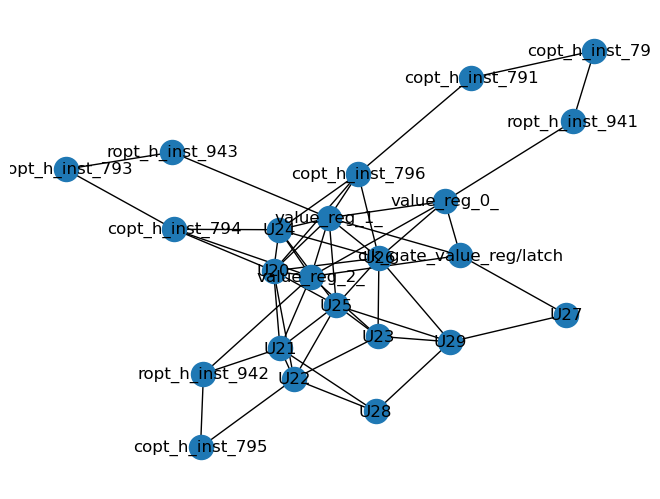

In [13]:
nx.draw(g, with_labels=True)

Finding out node connectivity between all pairs of nodes of G ([source](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.connectivity.all_pairs_node_connectivity.html)):

In [14]:
approximation.all_pairs_node_connectivity(g)

{'clk_gate_value_reg/latch': {'value_reg_0_': 4,
  'value_reg_2_': 4,
  'value_reg_1_': 4,
  'U20': 4,
  'U21': 4,
  'U22': 4,
  'U23': 4,
  'U24': 4,
  'U25': 4,
  'U26': 4,
  'U28': 3,
  'U27': 2,
  'U29': 4,
  'ropt_h_inst_941': 2,
  'copt_h_inst_790': 2,
  'copt_h_inst_791': 2,
  'copt_h_inst_793': 2,
  'copt_h_inst_794': 3,
  'copt_h_inst_795': 2,
  'copt_h_inst_796': 4,
  'ropt_h_inst_942': 3,
  'ropt_h_inst_943': 2},
 'value_reg_0_': {'clk_gate_value_reg/latch': 4,
  'value_reg_2_': 5,
  'value_reg_1_': 5,
  'U20': 5,
  'U21': 4,
  'U22': 4,
  'U23': 5,
  'U24': 5,
  'U25': 5,
  'U26': 5,
  'U28': 3,
  'U27': 2,
  'U29': 5,
  'ropt_h_inst_941': 2,
  'copt_h_inst_790': 2,
  'copt_h_inst_791': 2,
  'copt_h_inst_793': 2,
  'copt_h_inst_794': 3,
  'copt_h_inst_795': 2,
  'copt_h_inst_796': 5,
  'ropt_h_inst_942': 3,
  'ropt_h_inst_943': 2},
 'value_reg_2_': {'clk_gate_value_reg/latch': 4,
  'value_reg_0_': 5,
  'value_reg_1_': 8,
  'U20': 8,
  'U21': 6,
  'U22': 6,
  'U23': 5,
  'U2

Represent `am` using bipartite graph:

In [15]:
am_bipartite = np.vstack((np.hstack((np.zeros((23,23), dtype=int), counter_coo)),np.hstack((counter_coo.T, np.zeros((28, 28),dtype=int)))))
am_bipartite = (am_bipartite > 0).astype(int)

In [16]:
g_bipart = nx.from_numpy_array(am_bipartite)

In [17]:
# Verify if g_bipart is indeed a bipartite graph
bipartite.is_bipartite(g_bipart)

True

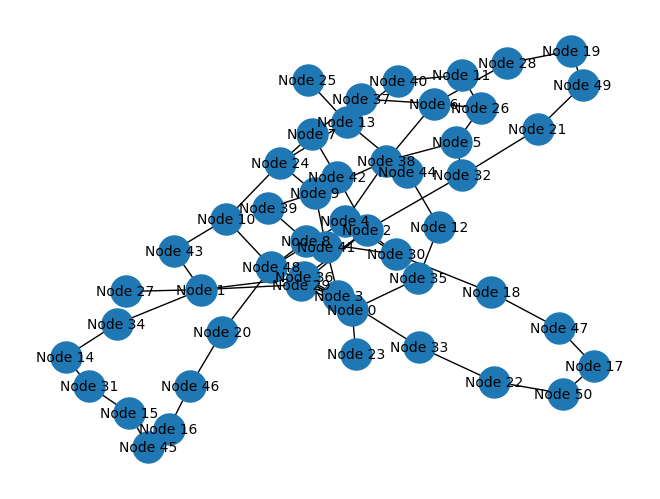

In [18]:
g_bipart.edges(23)
node_labels = {i: f"Node {i}" for i in range(am_bipartite.shape[0])}
pos = nx.spring_layout(g_bipart)
nx.draw(g_bipart, pos, with_labels=True, labels=node_labels, node_size=500, font_size=10)

In [19]:
am_bipartite_2 = np.vstack((np.hstack((np.zeros((23,23), dtype=int), counter_coo)),np.hstack((counter_coo.T, np.zeros((28, 28),dtype=int)))))


---

## EDA

### Data Preparation

In [20]:
# Load in counter congestion data
counter_congestion_data=np.load('../data/DigIC_dataset/counter/1/counter_congestion.npz')
lyr=list(counter_congestion_data['layerList']).index('M1')
ybl=counter_congestion_data['yBoundaryList']
xbl=counter_congestion_data['xBoundaryList']

In [21]:
# Load in xbar congestion data
xbar_congestion_data = np.load("../data/DigIC_dataset/xbar/1/xbar_congestion.npz")
lyr=list(xbar_congestion_data['layerList']).index('M1')
ybl=xbar_congestion_data['yBoundaryList']
xbl=xbar_congestion_data['xBoundaryList']

In [22]:
# Load in xbar feature data
with gzip.open("../data/DigIC_dataset/xbar/1/xbar.json.gz", 'rb') as f:
    xbar1 = json.loads(f.read().decode('utf-8'))

In [23]:
# Load in xbar connectivity data
xbar1conn = np.load("../data/DigIC_dataset/xbar/1/xbar_connectivity.npz")

In [24]:
xbar1coo = coo_matrix((xbar1conn['data'], (xbar1conn['row'], xbar1conn['col'])), shape=xbar1conn['shape'])

In [25]:
xbar_coo_arr = xbar1coo.toarray()

In [26]:
xbar_coo_arr.shape

(3952, 4482)

In [27]:
xbar_am = (np.dot(xbar_coo_arr, xbar_coo_arr.T) > 0).astype(int)
np.fill_diagonal(xbar_am, 0)

In [28]:
xbar_am

array([[0, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 0]])

In [29]:
xbar_g = nx.from_numpy_array(xbar_am)

### Distribution of Node Degree

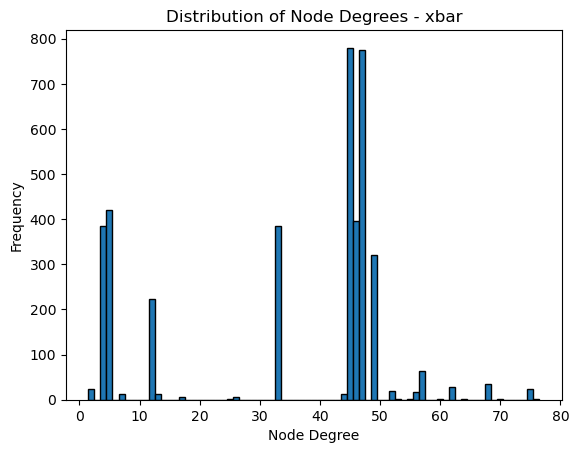

In [30]:
import matplotlib.pyplot as plt

def plot_degree_distribution(graph):
    degree_sequence = [d for n, d in graph.degree()]
    
    plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 2), align='left', edgecolor='black')
    plt.title('Distribution of Node Degrees - xbar')
    plt.xlabel('Node Degree')
    plt.ylabel('Frequency')
    plt.show()

plot_degree_distribution(xbar_g)

### Distribution of Node Betweeness Centrality for `counter` dataset

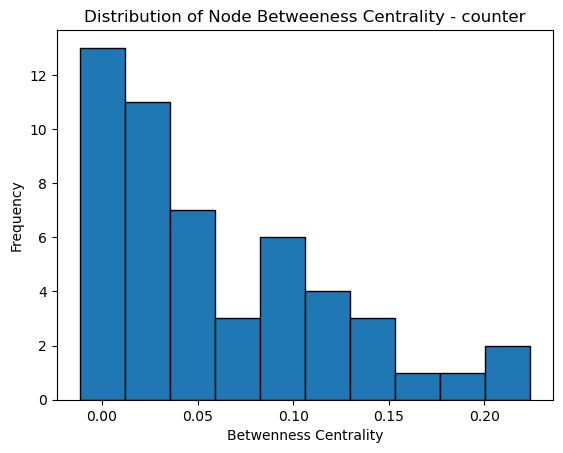

In [31]:
counter_centrality = (list(nx.betweenness_centrality(g_bipart).values()))
plt.hist(counter_centrality, bins=10, align='left', edgecolor='black')
plt.title('Distribution of Node Betweeness Centrality - counter')
plt.xlabel('Betwenness Centrality')
plt.ylabel('Frequency')
plt.show()

In [32]:
max(counter_centrality)

0.23586027657816386

In [33]:
min(counter_centrality)

0.0

In [34]:
np.percentile(counter_centrality, 75)

np.float64(0.1094795281749063)

In [35]:
np.median(counter_centrality)

np.float64(0.04817052362070371)

In [36]:
np.mean(counter_centrality)

np.float64(0.07201280512204883)

### Distribution of Node Betweeness Centrality for `xbar` dataset

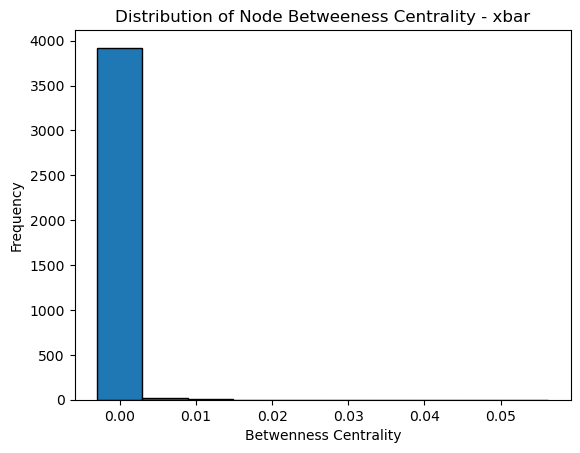

In [37]:
xbar_centrality = (list(nx.betweenness_centrality(xbar_g).values()))
plt.hist(xbar_centrality, bins=10, align='left', edgecolor='black')
plt.title('Distribution of Node Betweeness Centrality - xbar')
plt.xlabel('Betwenness Centrality')
plt.ylabel('Frequency')
plt.show()

In [38]:
max(xbar_centrality)

0.05922149306839112

In [39]:
min(xbar_centrality)

0.0

In [40]:
np.percentile(xbar_centrality, 75)

np.float64(0.0005893450814742105)

In [41]:
np.median(xbar_centrality)

np.float64(0.0005174837218137923)

In [42]:
np.mean(xbar_centrality)

np.float64(0.0006940710618934257)

In [43]:
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
    return((array[mid],ltl,gtl))
xbst=buildBST(counter_congestion_data['xBoundaryList'])
ybst=buildBST(counter_congestion_data['yBoundaryList'])

Calculate congestion

In [44]:
counter_congestion_data['demand'][3]

array([[0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 2, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [45]:
counter_congestion_data['capacity'][3]

array([[11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12],
       [10, 11, 12, 12, 12],
       [11, 12, 12, 12, 12],
       [11, 11, 12, 12, 12],
       [12, 12, 12, 12, 12],
       [11, 11, 12, 12, 12]])

In [46]:
congestion_3 = counter_congestion_data['demand'][3] / counter_congestion_data['capacity'][3]

In [47]:
congestion_1 = counter_congestion_data['demand'][1] / counter_congestion_data['capacity'][1]
congestion_1

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.09090909, 0.09090909, 0.5       , 0.33333333, 0.1       ],
       [0.33333333, 0.33333333, 0.1       , 0.33333333, 0.27272727],
       [0.85714286, 0.8       , 0.55555556, 0.5       , 0.41666667],
       [0.        , 0.11111111, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [48]:
counter_congestion_data['capacity'][3]

array([[11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12],
       [10, 11, 12, 12, 12],
       [11, 12, 12, 12, 12],
       [11, 11, 12, 12, 12],
       [12, 12, 12, 12, 12],
       [11, 11, 12, 12, 12]])

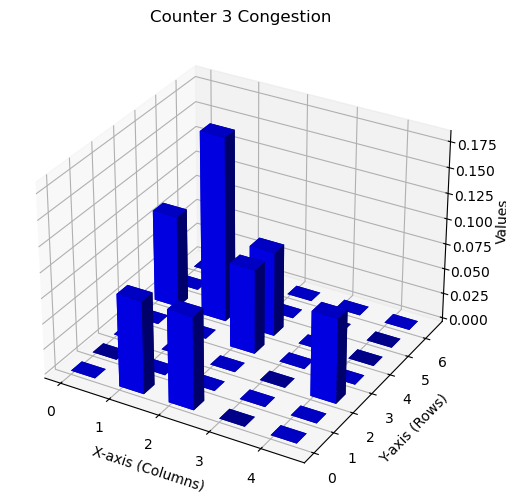

In [49]:
rows, cols = congestion_3.shape

# Create x and y coordinates for the congestion_3
x, y = np.meshgrid(np.arange(cols), np.arange(rows))
x = x.flatten()  # Flatten to 1D
y = y.flatten()  # Flatten to 1D
z = np.zeros_like(x)  # Base of the bars (z starts at 0)

# Flatten the congestion_3 values
values = congestion_3.flatten()

# Create the 3D bar plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot bars
dx = dy = 0.5  # Width and depth of the bars
dz = values    # Height of the bars
ax.bar3d(x, y, z, dx, dy, dz, shade=True, color='blue')

# Add labels
ax.set_xlabel('X-axis (Columns)')
ax.set_ylabel('Y-axis (Rows)')
ax.set_zlabel('Values')
ax.set_title('Counter 3 Congestion')

plt.show()

Congestion of the twelve different designs

/var/folders/qb/x2k0b7_x6j928j0nc2w6x7nc0000gn/T/ipykernel_42439/1729514983.py:2: RuntimeWarning: invalid value encountered in divide
  matrices = [np.nan_to_num(counter_congestion_data['demand'][i] / counter_congestion_data['capacity'][i], nan=0) for i in range(1, 13)]
/var/folders/qb/x2k0b7_x6j928j0nc2w6x7nc0000gn/T/ipykernel_42439/1729514983.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit titles and color bar


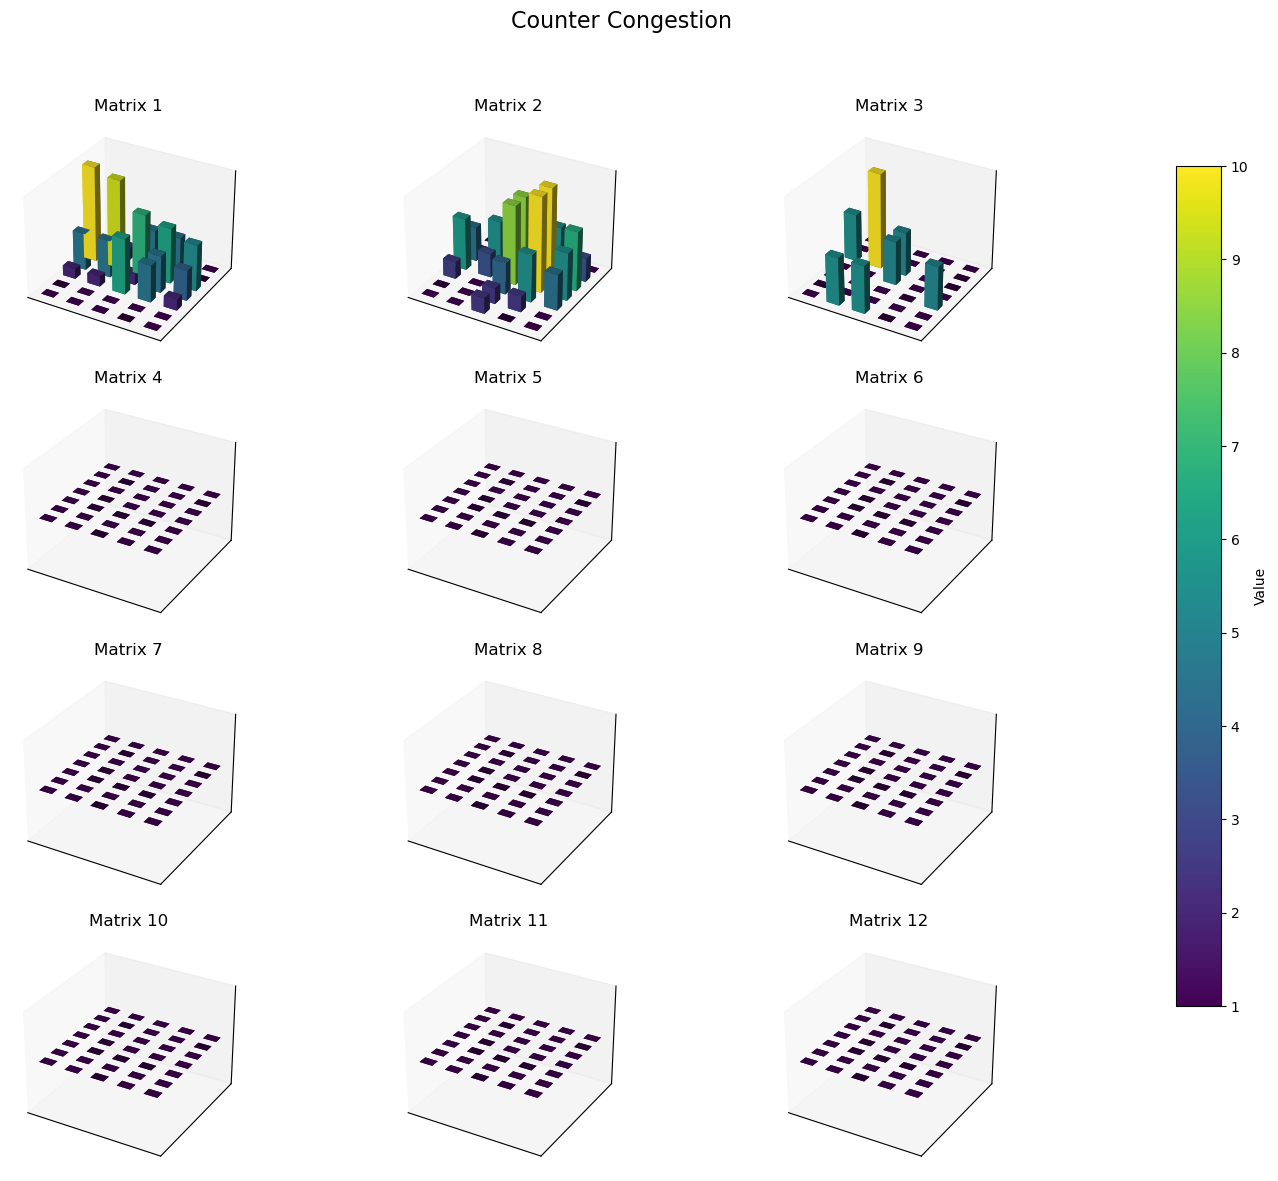

In [50]:
# Generate 12 random matrices for demonstration
matrices = [np.nan_to_num(counter_congestion_data['demand'][i] / counter_congestion_data['capacity'][i], nan=0) for i in range(1, 13)]

# Set up the figure with a 4x3 grid of subplots
fig = plt.figure(figsize=(15, 12))

# Iterate over the matrices and plot each in a subplot
for i, matrix in enumerate(matrices):
    ax = fig.add_subplot(4, 3, i + 1, projection='3d')
    
    # Dimensions of the matrix
    rows, cols = matrix.shape

    # Create x, y coordinates for the matrix
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    x = x.flatten()  # Flatten to 1D
    y = y.flatten()  # Flatten to 1D
    z = np.zeros_like(x)  # Base of the bars (z starts at 0)

    # Flatten the matrix values
    values = matrix.flatten()

    # Normalize the values for the colormap
    norm = plt.Normalize(values.min(), values.max())
    colors = cm.viridis(norm(values))  # Use a colormap (e.g., 'viridis')

    # Plot bars with colors
    dx = dy = 0.5  # Width and depth of the bars
    dz = values    # Height of the bars
    ax.bar3d(x, y, z, dx, dy, dz, color=colors, shade=True)

    # Set subplot titles
    ax.set_title(f"Matrix {i + 1}")
    
    # Optionally remove axis labels for cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# Add a color bar for the entire figure
fig.subplots_adjust(right=0.85)  # Make space for color bar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Position for the color bar
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(1, 10))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Value')

plt.suptitle("Counter Congestion", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit titles and color bar
plt.show()

Congestion on `xbar`data

In [51]:
xbar_congestion_data = np.load('../data/DigIC_dataset/xbar/1/xbar_congestion.npz')

In [52]:
xbar_congestion_0 = xbar_congestion_data['demand'][0] / xbar_congestion_data['capacity'][0]

/var/folders/qb/x2k0b7_x6j928j0nc2w6x7nc0000gn/T/ipykernel_42439/2848031962.py:1: RuntimeWarning: invalid value encountered in divide
  xbar_congestion_0 = xbar_congestion_data['demand'][0] / xbar_congestion_data['capacity'][0]


In [53]:
xbar_congestion_2 = xbar_congestion_data['demand'][2] / xbar_congestion_data['capacity'][2]

In [54]:
xbar_congestion_3 = xbar_congestion_data['demand'][3] / xbar_congestion_data['capacity'][3]

In [55]:
xbar_congestion_4 = np.nan_to_num(xbar_congestion_data['demand'][4] / xbar_congestion_data['capacity'][4], nan=0)

/var/folders/qb/x2k0b7_x6j928j0nc2w6x7nc0000gn/T/ipykernel_42439/1065234391.py:1: RuntimeWarning: invalid value encountered in divide
  xbar_congestion_4 = np.nan_to_num(xbar_congestion_data['demand'][4] / xbar_congestion_data['capacity'][4], nan=0)


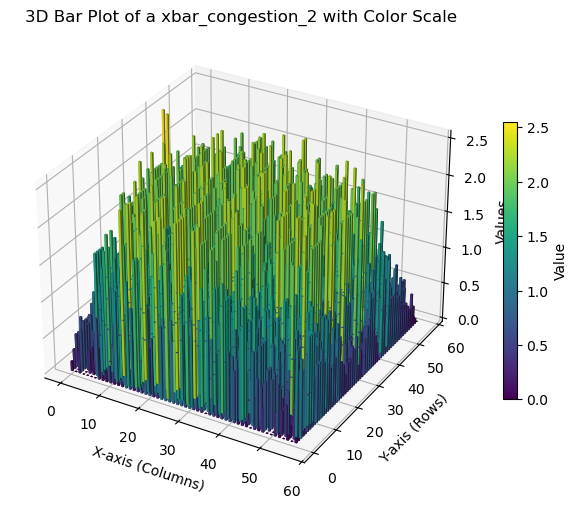

In [56]:
# Dimensions of the matrix
rows, cols = xbar_congestion_2.shape

# Create x and y coordinates for the xbar_congestion_3
x, y = np.meshgrid(np.arange(cols), np.arange(rows))
x = x.flatten()  # Flatten to 1D
y = y.flatten()  # Flatten to 1D
z = np.zeros_like(x)  # Base of the bars (z starts at 0)

# Flatten the xbar_congestion_3 values
values = xbar_congestion_2.flatten()

# Normalize the values for the colormap
norm = plt.Normalize(values.min(), values.max())
colors = cm.viridis(norm(values))  # Use a colormap (e.g., 'viridis')

# Create the 3D bar plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot bars with colors
dx = dy = 0.5  # Width and depth of the bars
dz = values    # Height of the bars
ax.bar3d(x, y, z, dx, dy, dz, color=colors, shade=True)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Value')

# Add labels
ax.set_xlabel('X-axis (Columns)')
ax.set_ylabel('Y-axis (Rows)')
ax.set_zlabel('Values')
ax.set_title('3D Bar Plot of a xbar_congestion_2 with Color Scale')

plt.show()


/var/folders/qb/x2k0b7_x6j928j0nc2w6x7nc0000gn/T/ipykernel_42439/413399798.py:2: RuntimeWarning: invalid value encountered in divide
  matrices = [np.nan_to_num(xbar_congestion_data['demand'][i] / xbar_congestion_data['capacity'][i], nan=0) for i in range(1, 13)]
/var/folders/qb/x2k0b7_x6j928j0nc2w6x7nc0000gn/T/ipykernel_42439/413399798.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit titles and color bar


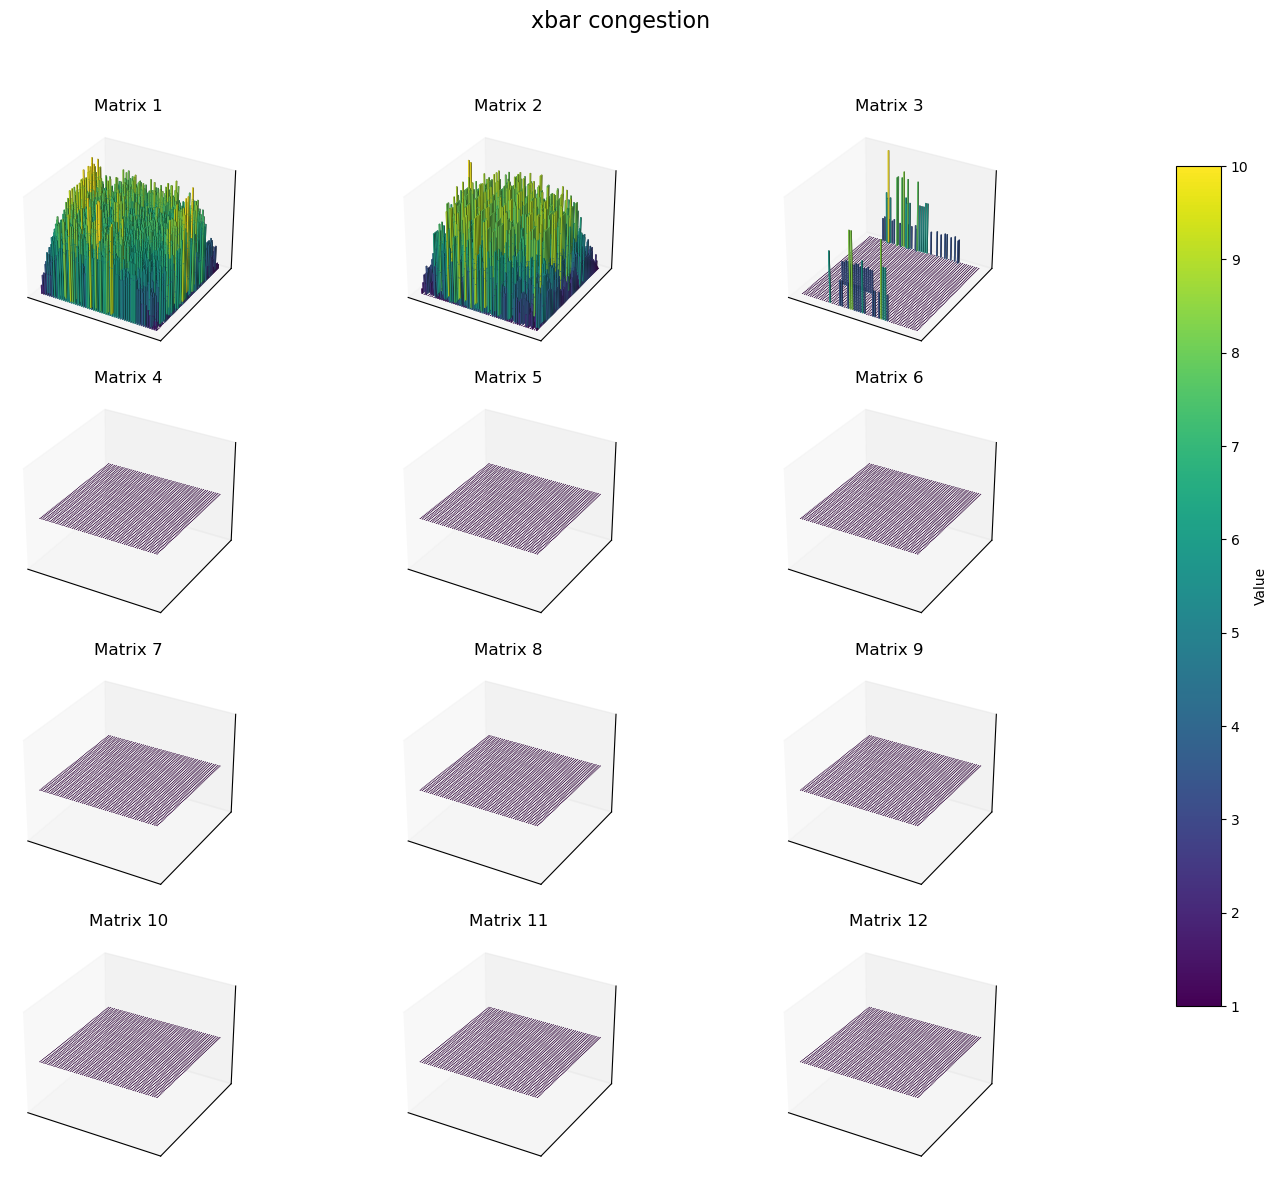

In [57]:
# Generate 12 random matrices for demonstration
matrices = [np.nan_to_num(xbar_congestion_data['demand'][i] / xbar_congestion_data['capacity'][i], nan=0) for i in range(1, 13)]

# Set up the figure with a 4x3 grid of subplots
fig = plt.figure(figsize=(15, 12))

# Iterate over the matrices and plot each in a subplot
for i, matrix in enumerate(matrices):
    ax = fig.add_subplot(4, 3, i + 1, projection='3d')
    
    # Dimensions of the matrix
    rows, cols = matrix.shape

    # Create x, y coordinates for the matrix
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    x = x.flatten()  # Flatten to 1D
    y = y.flatten()  # Flatten to 1D
    z = np.zeros_like(x)  # Base of the bars (z starts at 0)

    # Flatten the matrix values
    values = matrix.flatten()

    # Normalize the values for the colormap
    norm = plt.Normalize(values.min(), values.max())
    colors = cm.viridis(norm(values))  # Use a colormap (e.g., 'viridis')

    # Plot bars with colors
    dx = dy = 0.5  # Width and depth of the bars
    dz = values    # Height of the bars
    ax.bar3d(x, y, z, dx, dy, dz, color=colors, shade=True)

    # Set subplot titles
    ax.set_title(f"Matrix {i + 1}")
    
    # Optionally remove axis labels for cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# Add a color bar for the entire figure
fig.subplots_adjust(right=0.85)  # Make space for color bar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Position for the color bar
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(1, 10))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Value')

plt.suptitle("xbar congestion", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit titles and color bar
plt.show()